### **Imports**

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from regression import RegressionModel
from utils import *
from bases import *
from functools import partial
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({
        'font.family' : 'Times',
        'font.size' : 12,
        'axes.titlesize' : 12,
        'axes.labelsize' : 10,
        'axes.xmargin' : 0,
        'xtick.labelsize' : 10,
        'ytick.labelsize' : 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2,
        'lines.markersize': 3,
        'legend.shadow' : False,
        'legend.framealpha' : 1,
        'legend.fancybox' : True,
        'legend.edgecolor' : 'black',
        'patch.linewidth' : 0.75,
        'legend.handlelength' : 1,
        'text.usetex' : True,
        'text.latex.preamble' : r'''
    \usepackage{amsmath}
    \usepackage{amssymb}
    \usepackage{times}
    \usepackage{bm}
''',
    }) 

### **Initialize Models**

In [3]:
n = 20
output_var = 0.01
x = generate_data(n)
y = add_noise(x ** 3, output_var)

d, phi = identity_basis()
m_nobasis = RegressionModel(d, phi, 0, 0.05, output_var)

d, phi = bias_basis()
m_lines = RegressionModel(d, phi, 0, 0.05, output_var)

d, phi = poly_basis(3)
m_cubics = RegressionModel(d, phi, 0, 0.05, output_var)

d, phi, mu = nlm_basis([1, 64, 2, 1], x, y)
m_nlm = RegressionModel(d, phi, mu, 0.05, output_var)

d, phi, mu = nlm_basis([1, 256, 64, 1], x, y)
m_widenlm = RegressionModel(d, phi, mu, 0.05, output_var)


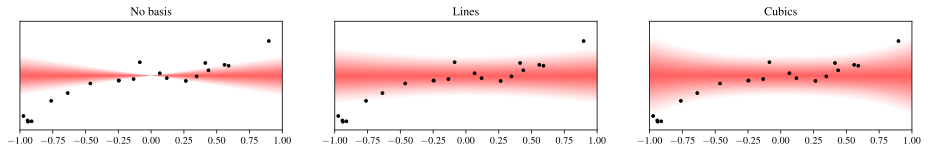

In [8]:
models = [m_nobasis, m_lines, m_cubics]
names = ['No basis', 'Lines', 'Cubics', 'Narrow NLM', 'Wide NLM']
fig, axs = plt.subplots(1, len(models), figsize=(16, 2))

for m, name, ax in zip(models, names, axs):
  ax.set_title(name)
  plot_diversity(m, ax)
  ax.scatter(x, y, c='k')

### **Plot Heatmaps**

In [13]:
heatmap = calculate_heatmap(models, partial(prior_pred_cross_entropy))
# ns = torch.tensor([1, 100, 1000])
# cross_entropy_heatmap = torch.zeros(len(ns), len(models), len(models))
# bf_success_heatmap = torch.zeros(len(ns), len(models), len(models))
# with tqdm(total=bf_success_heatmap.numel()) as pbar:
#     for i, n in tqdm(enumerate(ns)):
#         for j, m1 in enumerate(models):
#             for k, m2 in enumerate(models):
#                 cross_entropy_heatmap[i,j,k] = pred_cross_entropy(m1, m2, samples=500, n=n)
#                 bf_success_heatmap[i,j,k] = bf_success_rate(m1, m2, samples=500, n=n)
#                 pbar.update(1)
# torch.save(cross_entropy_heatmap, 'cross_entropy_heatmap.pt')
# torch.save(bf_success_heatmap, 'bf_success_heatmap.pt')


Heatmap done!: 100%|██████████| 16/16 [00:00<00:00, 362.41it/s]       


In [6]:
bf_success_heatmap = torch.load('bf_success_heatmap.pt')
cross_entropy_heatmap = torch.load('cross_entropy_heatmap.pt')

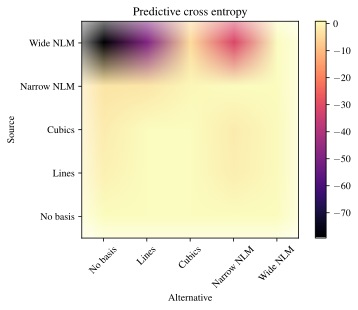

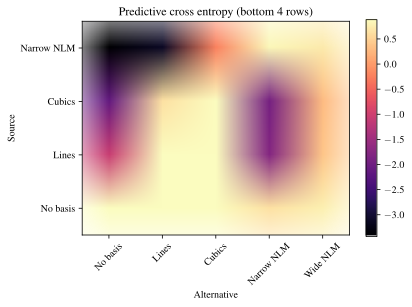

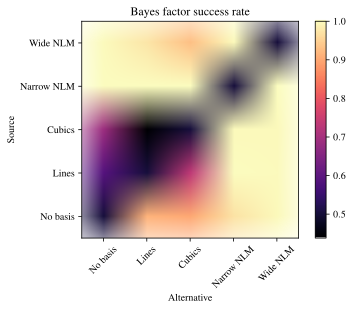

In [7]:
# legend = plt.imshow(heatmap, cmap='magma', interpolation='none', origin='lower')
# plt.colorbar(legend)
# plt.xticks(ticks=range(len(models)), labels=names, rotation=45)
# plt.yticks(ticks=range(len(models)), labels=names)
# plt.title('Predictive cross entropy')
# plt.ylabel('Source')
# plt.xlabel('Alternative')
# plt.show()

top_k = len(models)
hm = plt.imshow(cross_entropy_heatmap[2][:top_k,:top_k], cmap='magma', interpolation='none', origin='lower')
plt.colorbar(hm)
plt.xticks(ticks=range(top_k), labels=names[:top_k], rotation=45)
plt.yticks(ticks=range(top_k), labels=names[:top_k])
plt.title('Predictive cross entropy')
plt.ylabel('Source')
plt.xlabel('Alternative')
plt.show()

hm = plt.imshow(cross_entropy_heatmap[2][:top_k-1,:top_k], cmap='magma', interpolation='none', origin='lower')
plt.colorbar(hm)
plt.xticks(ticks=range(top_k), labels=names[:top_k], rotation=45)
plt.yticks(ticks=range(top_k-1), labels=names[:top_k-1])
plt.title('Predictive cross entropy (bottom 4 rows)')
plt.ylabel('Source')
plt.xlabel('Alternative')
plt.show()

hm = plt.imshow(bf_success_heatmap[2][:top_k,:top_k], cmap='magma', interpolation='none', origin='lower')
plt.colorbar(hm)
plt.xticks(ticks=range(top_k), labels=names[:top_k], rotation=45)
plt.yticks(ticks=range(top_k), labels=names[:top_k])
plt.title('Bayes factor success rate')
plt.ylabel('Source')
plt.xlabel('Alternative')
plt.show()

### **Decomposition**

In [16]:
deg = 16
vars = [taylor_coeff_var(m, deg) for m in models]

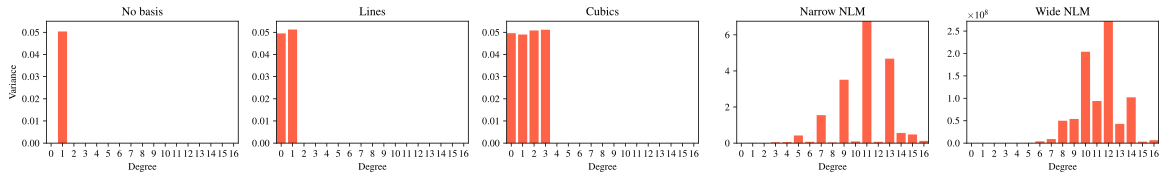

In [33]:
fig, axs = plt.subplots(1, len(models), figsize=(20, 2.25))

for var, name, ax in zip(vars, names, axs):
  ax.set_title(name)
  ax.set_xlabel('Degree')
  ax.bar(range(deg+1), var, color='tomato')
  ax.set_xticks(range(deg+1))
  ax.set_ylim(0, max(0.055, var.max()))
axs[0].set_ylabel('Variance')

plt.show()

